<a href="https://colab.research.google.com/github/Yong-Hui-Liew/PyTorch-Adventure/blob/main/02_pytorch_exercise_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [94]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
NUM_SAMPLES = 1000
RANDOM_SEED = 42

X_moons, y_moons = make_moons(n_samples=NUM_SAMPLES,
                              noise=0.03,
                              random_state=RANDOM_SEED)
X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X_moons,
                                                    y_moons,
                                                    test_size=0.2,
                                                    random_state=42)

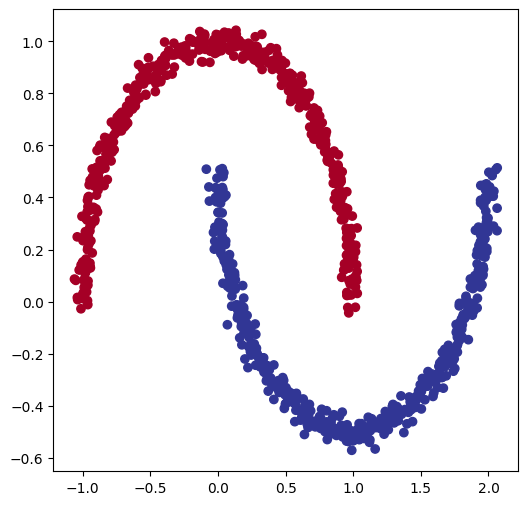

In [95]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap=plt.cm.RdYlBu);

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [96]:
import torch
from torch import nn
class MoonModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0 = MoonModel()
model_0

MoonModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [97]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [98]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy


In [99]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [100]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_true=y_train,
                          y_pred=y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    model_0.eval()
    with torch.inference_mode():
      test_logits = model_0(X_test).squeeze()

    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_preds)

    print(f"epoch:{epoch} | loss:{loss:.5f} | train_acc:{train_acc:.2f} | test_loss:{test_loss:.2f} | test_acc:{test_acc:.2f}")

epoch:0 | loss:0.69537 | train_acc:37.75 | test_loss:0.69 | test_acc:49.50
epoch:10 | loss:0.68200 | train_acc:76.50 | test_loss:0.68 | test_acc:73.00
epoch:20 | loss:0.66786 | train_acc:79.75 | test_loss:0.67 | test_acc:77.00
epoch:30 | loss:0.65071 | train_acc:77.62 | test_loss:0.65 | test_acc:73.00
epoch:40 | loss:0.62607 | train_acc:76.12 | test_loss:0.63 | test_acc:69.00
epoch:50 | loss:0.59334 | train_acc:75.12 | test_loss:0.60 | test_acc:71.50
epoch:60 | loss:0.55276 | train_acc:76.12 | test_loss:0.56 | test_acc:72.50
epoch:70 | loss:0.50709 | train_acc:77.25 | test_loss:0.52 | test_acc:74.50
epoch:80 | loss:0.46099 | train_acc:78.62 | test_loss:0.47 | test_acc:74.50
epoch:90 | loss:0.41996 | train_acc:80.25 | test_loss:0.43 | test_acc:75.50
epoch:100 | loss:0.38636 | train_acc:81.88 | test_loss:0.40 | test_acc:77.00
epoch:110 | loss:0.35933 | train_acc:83.00 | test_loss:0.37 | test_acc:78.50
epoch:120 | loss:0.33713 | train_acc:84.12 | test_loss:0.35 | test_acc:80.00
epoch:130 

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [101]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper function.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:   # wb: write permissions
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


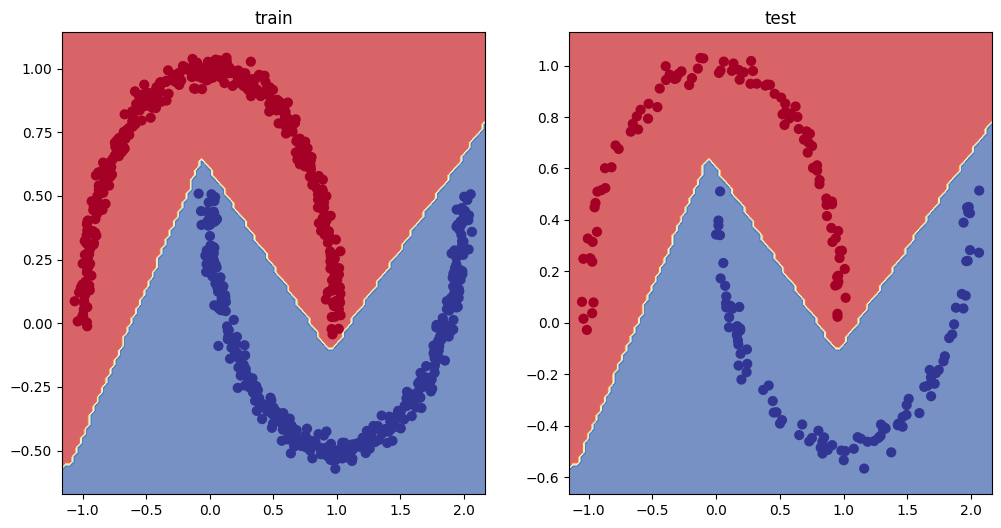

In [102]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
* Feel free to reference the ML cheatsheet website for the formula.

In [103]:
def tanh(x:torch.Tensor)->torch.Tensor:
  e = torch.exp(x)
  return (e - 1/e)/(e + 1/e)

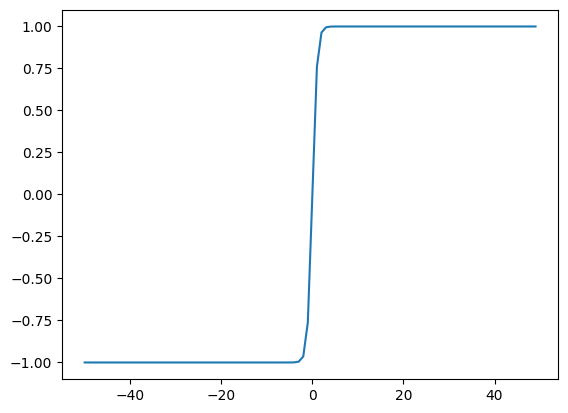

In [106]:
x = torch.arange(-50, 50, 1)
y = tanh(x)
plt.plot(x, y)

## 7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

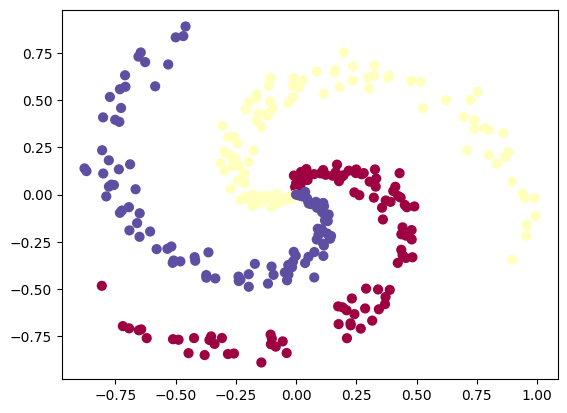

In [107]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [133]:
import torch
from torch import nn

# Build model
class SpiralModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=3), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_1 = SpiralModel(input_features=2,
                    output_features=3,
                    hidden_units=8).to(device)
model_1

SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [134]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),
                            lr=0.1)

In [135]:
X = X.type(torch.float)
y = y.type(torch.LongTensor)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [136]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_1.train()
  y_logits = model_1(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_true=y_train,
                          y_pred=y_preds)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % 10 == 0:
    model_1.eval()
    with torch.inference_mode():
      test_logits = model_1(X_test)

    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_preds)

    print(f"epoch:{epoch} | loss:{loss:.5f} | train_acc:{train_acc:.2f} | test_loss:{test_loss:.2f} | test_acc:{test_acc:.2f}")

epoch:0 | loss:1.11370 | train_acc:17.08 | test_loss:1.09 | test_acc:46.67
epoch:10 | loss:0.61829 | train_acc:63.33 | test_loss:0.72 | test_acc:53.33
epoch:20 | loss:0.28192 | train_acc:89.17 | test_loss:0.30 | test_acc:90.00
epoch:30 | loss:0.11044 | train_acc:96.25 | test_loss:0.16 | test_acc:98.33
epoch:40 | loss:0.05695 | train_acc:99.17 | test_loss:0.18 | test_acc:98.33
epoch:50 | loss:0.03924 | train_acc:99.17 | test_loss:0.24 | test_acc:98.33
epoch:60 | loss:0.03264 | train_acc:99.17 | test_loss:0.30 | test_acc:98.33
epoch:70 | loss:0.02905 | train_acc:99.17 | test_loss:0.27 | test_acc:98.33
epoch:80 | loss:0.02673 | train_acc:99.17 | test_loss:0.26 | test_acc:98.33
epoch:90 | loss:0.02502 | train_acc:99.17 | test_loss:0.27 | test_acc:98.33
epoch:100 | loss:0.02676 | train_acc:99.17 | test_loss:0.26 | test_acc:98.33
epoch:110 | loss:0.02457 | train_acc:99.17 | test_loss:0.27 | test_acc:98.33
epoch:120 | loss:0.02155 | train_acc:99.17 | test_loss:0.29 | test_acc:98.33
epoch:130 

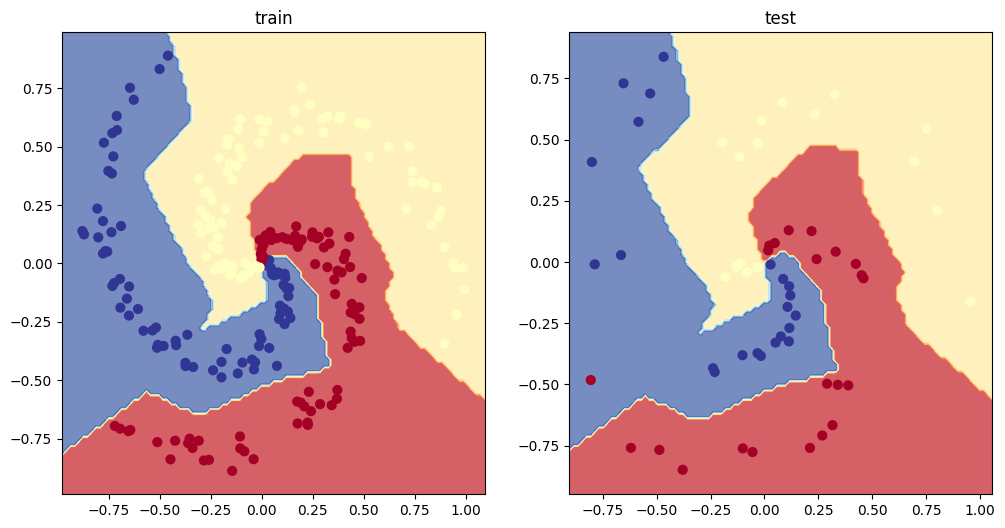

In [137]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_1, X_test, y_test)